In [53]:
stations_info = """
1113139	11#125#S#OR
1114211	11#5#N#ML
1108405	11#805#N#ML
1108509	11#5#N#ML
1116023	11#163#N#FF
1108688	11#5#N#OR
1100340	11#5#N#FR
1108507	11#5#N#ML
1118707	11#5#N#ML
1122479	11#15#S#ML
1100706	11#94#E#FR
1111548	11#805#S#ML
1125265	11#15#S#ML
1118020	11#805#N#ML
1119637	11#5#N#ML
1118552	11#52#W#ML
1108627	11#78#W#ML
1122645	11#8#E#ML
1108496	11#15#S#OR
1108649	11#78#E#ML
1108707	11#78#E#OR
1119021	11#125#N#ML
1121657	11#67#N#CH
1108650	11#78#E#OR
1111527	11#52#W#ML
1100384	11#5#S#FR
1108423	11#8#W#ML
1108501	11#94#E#ML
1108297	11#94#W#ML
1108590	11#15#N#ML
1115794	11#15#S#ML
1119470	11#94#W#FF
1118957	11#805#S#ML
1117724	11#5#S#ML
1123072	11#5#S#ML
1100549	11#15#S#FR
1108406	11#805#N#OR
1108717	11#15#N#ML
1121663	11#67#S#CH
1118060	11#5#N#FF
1116574	11#8#W#ML
1108581	11#805#N#OR
1113266	11#125#N#ML
1121158	11#15#S#ML
1108342	11#8#W#OR
1111561	11#8#E#ML
1122763	11#8#W#FF
1123300	11#905#E#OR
1122942	11#15#N#ML
"""

In [56]:
stations = {}
for station in stations_info.split('\n')[1:-1]:
    station_id, info = station.split('\t')
    district, route, direction, linetype = info.split('#')
    stations[station_id] = (district, route, direction, linetype)
print stations.items()[:3]

[('1108423', ('11', '8', 'W', 'ML')), ('1108707', ('11', '78', 'E', 'OR')), ('1118020', ('11', '805', 'N', 'ML'))]


In [57]:
import os
from datetime import datetime, timedelta

def extract_filename(p):
    return p.split('/')[1].split('.')[0]

filenames = [os.path.join('traffic', f) for f in next(os.walk('traffic/'))[2]]
date_format = '%Y-%m-%d %H:%M:%S'
delta = timedelta(hours=1)

data = {}
for filename in filenames:
    station = extract_filename(filename)
    data[station] = []
    last_data = None
    with open(filename) as f:
        for line in f:
            raw_date, raw_flow = line.strip().split('\t')
            date = datetime.strptime(raw_date, date_format)
            if raw_flow == 'None':
                raw_flow = 'nan'
            while last_data and last_data + delta < date:
                missing_date = last_data + delta
                data[station].append((missing_date, float('nan')))
                last_data = missing_date
            data[station].append((date, float(raw_flow)))
            last_data = date

        # Drop incomplete data at the begining and end
        st = 0
        while data[station][st][0].hour != 0:
            st = st + 1
        ed = len(data[station])
        while data[station][ed-1][0].hour != 23:
            ed = ed - 1
        data[station] = data[station][st:ed]

In [179]:
from math import isnan
import numpy as np

def count_wday(sd):
    last = -1
    count = 0
    for a, b in sd:
        if a != last:
            if last >= 0:
                print count,
            last = a
            count = 0
        count = count + 1
    print count

def get_vectors(station):
    def vectors_fillna(vectors):
        average = np.nanmean(vectors, axis=0)
        for i in range(len(vectors)):
            for j in range(len(vectors[i])):
                if isnan(vectors[i][j]):
                    vectors[i][j] = average[j]
        return vectors

    vectors = []
    p = data[station]
    for k in range(0, len(p), 7*24):
        if k + 7*24 <= len(p):
            vectors.append([(b) for a, b in p[k:k+7*24]])
    
    days = []
    for k in range(7*24):
        days.append(p[k][0])
    # Monday is 0 and Sunday is 6
    result = np.array(vectors)
    return days, vectors_fillna(result)


In [248]:
%matplotlib inline

from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

def PCA_analysis(station, outlier = None, figure_id = 1):
    dates, vectors = get_vectors(station)
    X = vectors - np.mean(vectors)
    pca = PCA(n_components=2)
    pca.fit(X)
    print 'Before outliers removed:', (pca.explained_variance_ratio_)
    components0 = pca.components_[:]
    
    # row and column sharing
    f, ((ax1, ax4), (ax2, ax5), (ax3, ax6)) = plt.subplots(3, 2, figsize=(15,15))
    plt.suptitle(str(station))

    ax1.plot(dates, np.mean(vectors, axis=0))
    weekdaysFmt = mdates.DateFormatter('%a')
    ax1.xaxis.set_major_formatter(weekdaysFmt)
    
    ax2.plot(components0[0], color='blue', alpha=1.0)
    ax2.plot(components0[1], color='red', alpha=0.3)
    
    for v in vectors:
        ax3.plot(v.dot(components0[0]), v.dot(components0[1]),
                 'o', markersize=7, color='blue', alpha=0.5, label='class1')

    if not outlier:
        return

    lx, rx, ly, ry = outlier
    outliers = []
    outliers_index = []
    for idx, vector in enumerate(vectors):
        x = vector.dot(components0[0])
        y = vector.dot(components0[1])
        if x < lx or rx < x or y < ly or ry < y:
            outliers.append(vector)
            outliers_index.append(idx)
    print "Outliers: %d/%d" % (len(outliers), len(vectors))
    vectors = [vectors[t] for t in range(len(vectors)) if t not in outliers_index]

    X = vectors - np.mean(vectors)
    pca = PCA(n_components=2)
    pca.fit(X)
    print 'After outliers removed:', (pca.explained_variance_ratio_)
    components = pca.components_
    
    ax4.plot(dates, np.mean(vectors, axis=0))
    ax4.xaxis.set_major_formatter(weekdaysFmt)
    
    ax5.plot(components[0], color='blue', alpha=1.0)
    ax5.plot(components[1], color='red', alpha=0.3)
    
    for v in vectors:
        ax6.plot(v.dot(components0[0]), v.dot(components0[1]),
                 'o', markersize=7, color='blue', alpha=1.0, label='normal')
    for v in outliers:
        ax6.plot(v.dot(components0[0]), v.dot(components0[1]),
                 'o', markersize=7, color='red', alpha=0.5, label='outliers')
    print

Before outliers removed: [ 0.35905106  0.17275573]
Outliers: 12/51
After outliers removed: [ 0.24817585  0.15423063]

Before outliers removed: [ 0.31162749  0.18303369]
Outliers: 5/51
After outliers removed: [ 0.17979356  0.11635602]

Before outliers removed: [ 0.30428524  0.15440154]
Before outliers removed: [ 0.88407545  0.0362036 ]


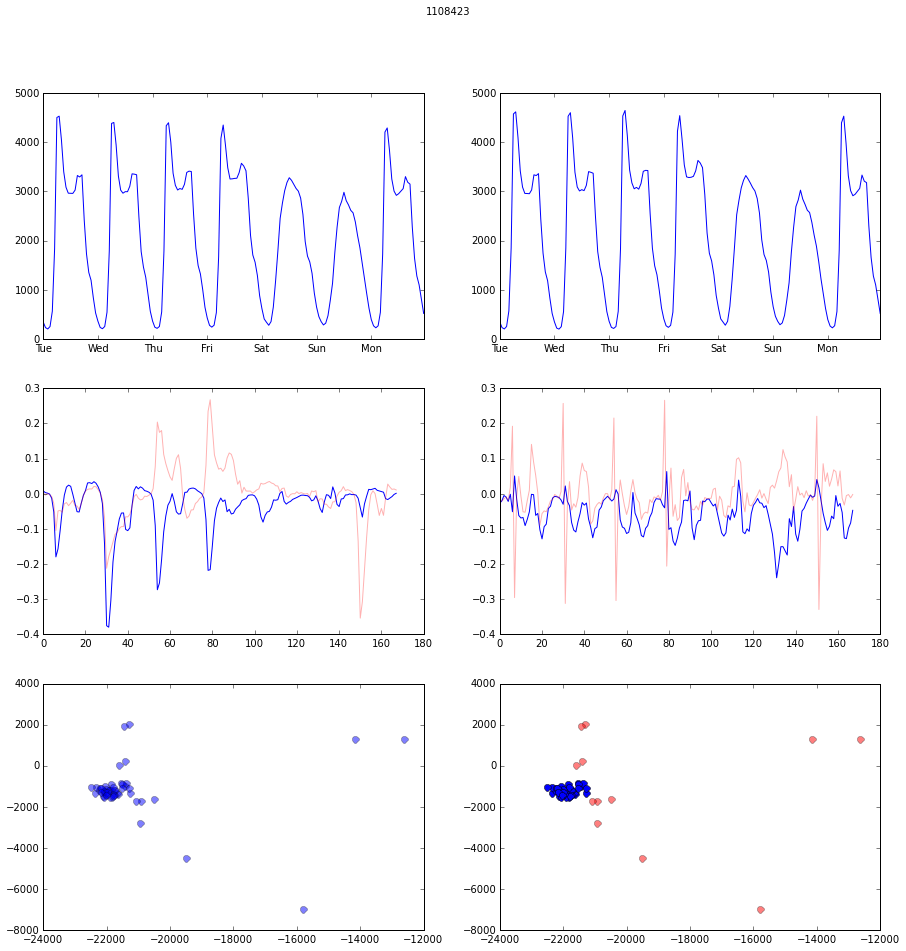

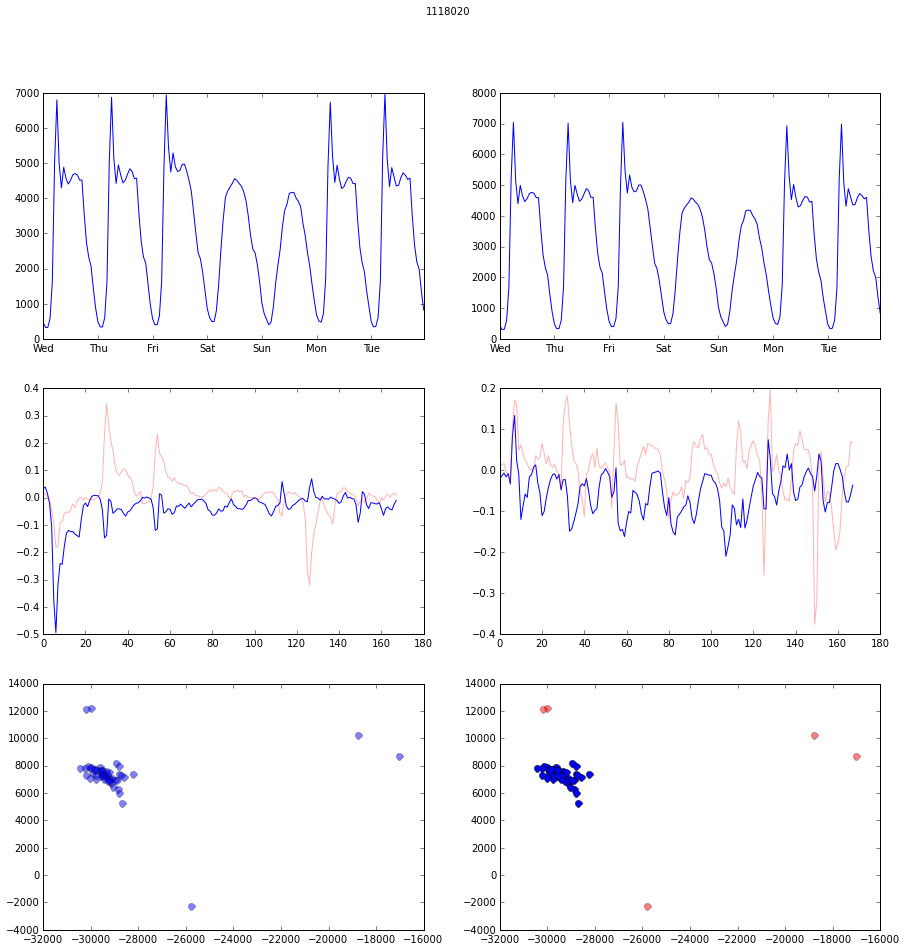

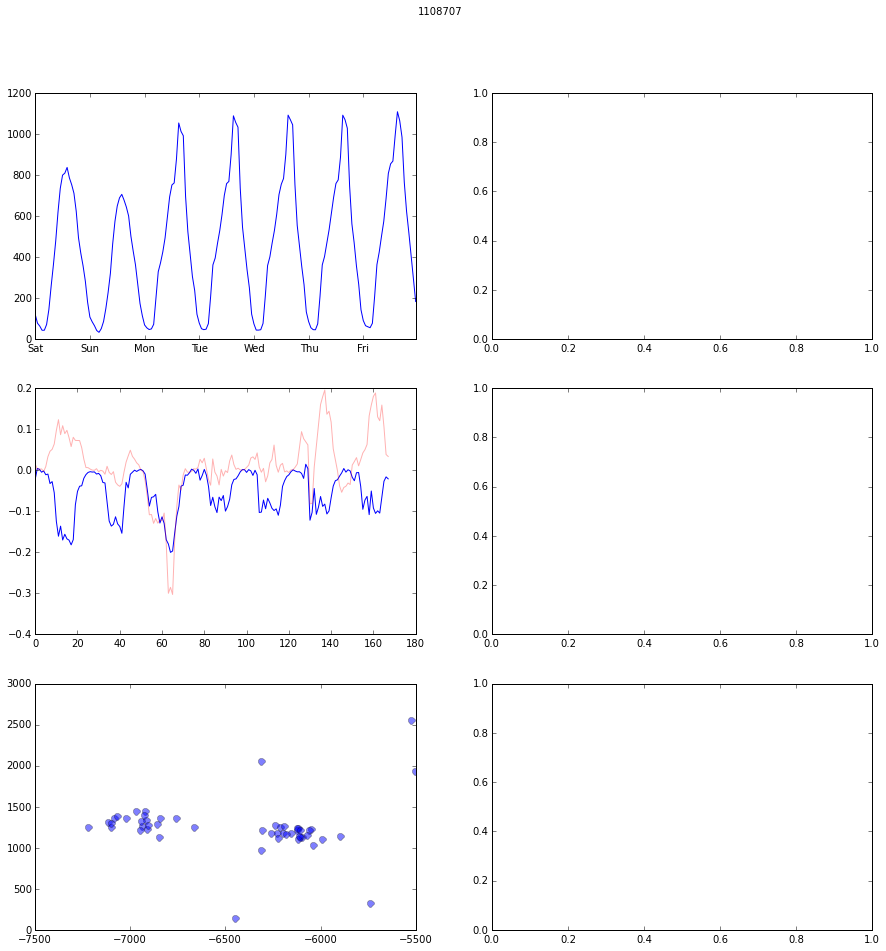

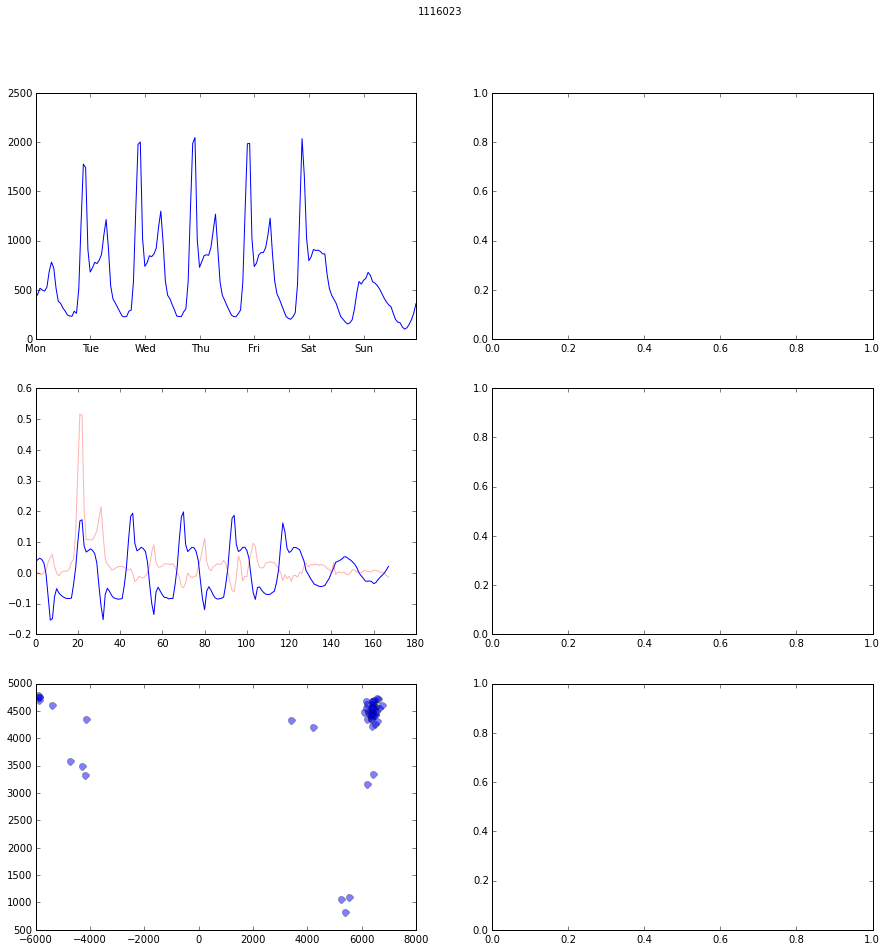

In [266]:
station1, station2, station3, station4 = '1108423', '1118020', '1108707', '1116023' # '1108627' # Route 8, 805, 78, 163, 78
PCA_analysis(station1, (-24000, -21200, -2000, -500), 1)
PCA_analysis(station2, (-31000, -28000, 4000, 9000), 2)
PCA_analysis(station3, None, 3)
PCA_analysis(station4, None, 4)

In [253]:
print len(stations), len(data)

49 49


In [255]:
print data.keys()
print stations.keys()

['1108423', '1108707', '1118020', '1100706', '1108649', '1108406', '1119021', '1108590', '1117724', '1122645', '1123072', '1122942', '1115794', '1116023', '1108627', '1121657', '1113266', '1116574', '1118552', '1108688', '1108405', '1119470', '1118060', '1122763', '1122479', '1114211', '1108650', '1118707', '1123300', '1108581', '1111561', '1111548', '1108507', '1108496', '1108501', '1121158', '1108342', '1108509', '1108717', '1113139', '1100340', '1100549', '1111527', '1118957', '1119637', '1100384', '1108297', '1121663', '1125265']
['1108423', '1108707', '1118020', '1108405', '1108649', '1108406', '1119021', '1108590', '1117724', '1122645', '1125265', '1122942', '1115794', '1116023', '1108627', '1121657', '1113266', '1116574', '1118552', '1108688', '1100706', '1118060', '1122763', '1122479', '1114211', '1118707', '1118957', '1123300', '1108581', '1111561', '1111548', '1108507', '1108496', '1108501', '1121158', '1108342', '1108509', '1108717', '1113139', '1100340', '1100549', '1111527

In [138]:
%matplotlib inline

from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

def PCA_analysis(station):
    vectors = get_vectors(station)
    X = vectors - np.mean(vectors)
    pca = PCA(n_components=2)
    pca.fit(X)
    print(pca.explained_variance_ratio_)

    components = pca.components_
    
    plt.figure(1)
    plt.plot(np.mean(vectors, axis=0))
    plt.figure(2)
    plt.plot(components[0], color='blue', alpha=1.0)
    plt.plot(components[1], color='red', alpha=0.3)
    plt.figure(3)
    for v in vectors:
        plt.plot(v.dot(components[0]), v.dot(components[1]),
                 'o', markersize=7, color='blue', alpha=0.5, label='class1')

def PCA_analysis_outlier(station, outlier):
    vectors = get_vectors(station)
    X = vectors - np.mean(vectors)
    pca = PCA(n_components=2)
    pca.fit(X)
    print 'Before outliers removed:', (pca.explained_variance_ratio_)
    components0 = pca.components_[:]

    lx, rx, ly, ry = outlier
    outliers = []
    outliers_index = []
    for idx, vector in enumerate(vectors):
        x = vector.dot(components0[0])
        y = vector.dot(components0[1])
        if x < lx or rx < x or y < ly or ry < y:
            outliers.append(vector)
            outliers_index.append(idx)
    print "Outliers: %d/%d" % (len(outliers), len(vectors))
    vectors = [vectors[t] for t in range(len(vectors)) if t not in outliers_index]

    X = vectors - np.mean(vectors)
    pca = PCA(n_components=2)
    pca.fit(X)
    print 'After outliers removed:', (pca.explained_variance_ratio_)
    components = pca.components_
    
    plt.figure(1)
    plt.plot(np.mean(vectors, axis=0))
    plt.figure(2)
    plt.plot(components[0], color='blue', alpha=1.0)
    plt.plot(components[1], color='red', alpha=0.3)
    plt.figure(3)
    for v in vectors:
        plt.plot(v.dot(components0[0]), v.dot(components0[1]),
                 'o', markersize=7, color='blue', alpha=1.0, label='normal')
    for v in outliers:
        plt.plot(v.dot(components0[0]), v.dot(components0[1]),
                 'o', markersize=7, color='red', alpha=0.5, label='outliers')

In [213]:
%matplotlib inline

from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

def PCA_analysis(station, outlier = None, figure_id = 1):
    dates, vectors = get_vectors(station)
    X = vectors - np.mean(vectors)
    pca = PCA(n_components=2)
    pca.fit(X)
    print 'Before outliers removed:', (pca.explained_variance_ratio_)
    components0 = pca.components_[:]
    
    figure = plt.figure(figure_id, figsize=(15,15))
    plt.suptitle(str(station))

    ax = plt.subplot2grid((3,2),(0,0))
    plt.plot(dates, np.mean(vectors, axis=0))
    figure.axes[0].format_xdata = mdates.DateFormatter('%a')
    # figure.autofmt_xdate()
    
    plt.subplot2grid((3,2),(1,0))
    plt.plot(components0[0], color='blue', alpha=1.0)
    plt.plot(components0[1], color='red', alpha=0.3)
    
    plt.subplot2grid((3,2),(2,0))
    for v in vectors:
        plt.plot(v.dot(components0[0]), v.dot(components0[1]),
                 'o', markersize=7, color='blue', alpha=0.5, label='class1')

    if not outlier:
        return

    lx, rx, ly, ry = outlier
    outliers = []
    outliers_index = []
    for idx, vector in enumerate(vectors):
        x = vector.dot(components0[0])
        y = vector.dot(components0[1])
        if x < lx or rx < x or y < ly or ry < y:
            outliers.append(vector)
            outliers_index.append(idx)
    print "Outliers: %d/%d" % (len(outliers), len(vectors))
    vectors = [vectors[t] for t in range(len(vectors)) if t not in outliers_index]

    X = vectors - np.mean(vectors)
    pca = PCA(n_components=2)
    pca.fit(X)
    print 'After outliers removed:', (pca.explained_variance_ratio_)
    components = pca.components_
    
    plt.subplot2grid((3,2),(0,1))
    plt.plot(np.mean(vectors, axis=0))
    
    plt.subplot2grid((3,2),(1,1))
    plt.plot(components[0], color='blue', alpha=1.0)
    plt.plot(components[1], color='red', alpha=0.3)
    
    plt.subplot2grid((3,2),(2,1))
    for v in vectors:
        plt.plot(v.dot(components0[0]), v.dot(components0[1]),
                 'o', markersize=7, color='blue', alpha=1.0, label='normal')
    for v in outliers:
        plt.plot(v.dot(components0[0]), v.dot(components0[1]),
                 'o', markersize=7, color='red', alpha=0.5, label='outliers')
    print